In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps


In [19]:
K = np.diag(np.array([1,2,3]))
M = np.diag(np.array([7,8,9]))
N = np.array([[1,2,3],[4,5,6],[7,8,9]])
NtN = N.T @ N
print(N@K)

[[ 1  4  9]
 [ 4 10 18]
 [ 7 16 27]]


## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R}(x) = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

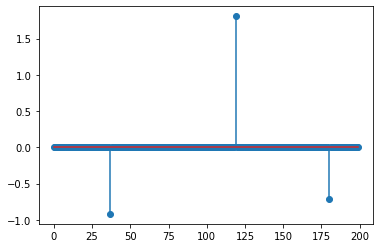

In [32]:
#Initializations
features = 100;
samples = 200;
A = np.random.randn(features,samples)
#Try different matrices
#y = np.random.randn(features)
#Initialize some random sparse solution
x0 = np.zeros((samples,1))
p = np.random.permutation(samples)
x0[p[:3]] = np.random.randn(3,1)
x0 = np.reshape(x0,-1)
y = A@x0
#lam = .9 * np.max( np.abs(A.T @ y))
lam = np.max(np.abs(A.T@y))/10
plt.stem(x0)
plt.show()

In [4]:
np.size(x0)

200

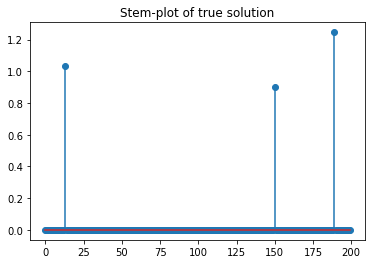

In [47]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.stem(x0)
ax.set_title('Stem-plot of true solution')
plt.savefig('foo.png')

In [3]:
def errL2(A,x,y):   #Return L2 error of Ax-y
    dif = A@x - y
    return dif.T @ dif

In [4]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [5]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,omg): 
    return np.sign(x) * np.maximum(np.abs(x)-omg*np.ones(np.size(x)),0)

In [6]:
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)

In [7]:
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))

Final f(x)+g(x): 2.9195347294226925
Original soln: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.03510583 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.  

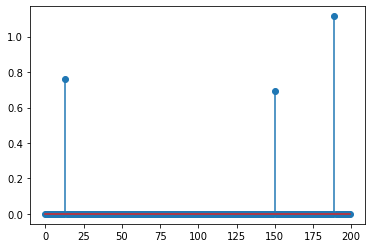

Text(0.5, 1.0, 'ln(f(x)+g(x))')

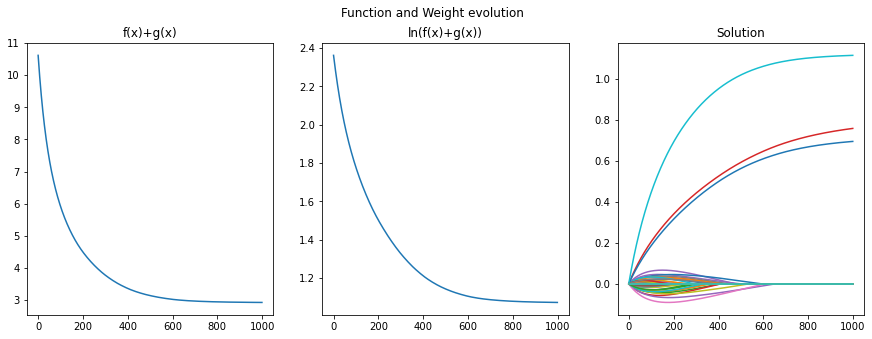

In [8]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 1000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
for i in range(niter):
    #print("Iteration", i)
    x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
    #fftx = np.fft.fft(x,10000)
    #fftdiff = fftk * fftx - ffty
    #gradconv = np.fft.ifft(fftkc * fftdiff,samples)
    #x = prox(x - (omg/lam)*gradconv,omg)
    xtemp[:,i] = x
    errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs[0].plot(funcvec.T);
axs[0].set_title('f(x)+g(x)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec.T));
axs[1].set_title('ln(f(x)+g(x))')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [8]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [9]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Final f(x)+g(x): 1.8700309985052441
Final soln: [-4.77816137e-12  2.88294627e-12  2.30618341e-10  4.82753458e-11
  9.34084358e-11 -5.37562742e-11  7.30026834e-12  3.64806169e-10
 -6.73580225e-10  1.79413909e-11  6.64288620e-11 -7.42386800e-11
  1.31218800e-11  3.51774139e-11 -6.11291612e-10  6.43216643e-01
  2.29218355e-10 -4.60887504e-10  3.23184902e-12 -9.76298636e-11
  2.05933153e-10  2.25320727e-10  3.60089126e-08 -6.05144408e-10
  3.71522385e-10  5.56587940e-10 -1.86640189e-10 -3.86434366e-10
  3.57596892e-09 -1.42180608e-11  9.76811909e-11 -2.82522276e-09
 -2.68521004e-11 -1.31910589e-10 -7.50276757e-10 -5.84142575e-10
  9.16963536e-12 -1.28546069e-08 -1.06639936e-09 -3.70510846e-12
 -3.18743064e-10  6.95027099e-12 -1.03478618e-11 -1.35803600e-08
  3.57139094e-11 -1.19009610e-09 -8.62477885e-11  1.29886601e-11
  2.14423562e-10  2.57223105e-10  4.37529408e-10 -5.23933856e-13
  8.22904451e-13  1.02708771e-09 -1.09595082e-10  3.85622747e-10
  1.13785473e-10 -1.00255462e-10  3.719274

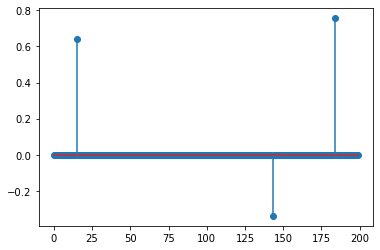

Text(0.5, 1.0, 'Solution')

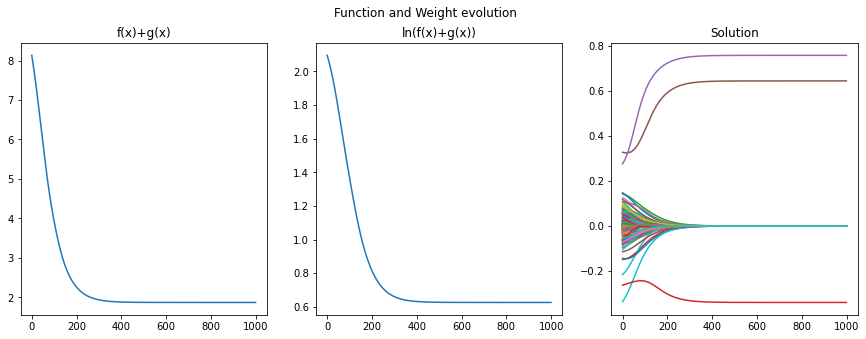

In [13]:
step = 0.01
niter = 1000
errvec2 = np.zeros(niter)
funcvec2 = np.zeros(niter)
v = np.random.randn(samples)
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
for i in range(niter):
    #print("Iteration", i)
    grad = Gradf(A,y,v,lam)
    #grad = Gradf_conv(A,fftk,fftkc,y,v,lam)
    v = v - step*grad
    x = v * find_u(A,y,v,lam)
    #x = v * find_u_conv(fftk,fftkc,ffty,v,lam)
    xtemp2[:,i] = x
    errvec2[i] = errL2(A,x,y)
    funcvec2[i] = funcreg(A,x,y,lam)
    
print("Final f(x)+g(x):", funcvec2[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs2[1].plot(np.log(funcvec2.T));
axs2[1].set_title('ln(f(x)+g(x))')
axs2[0].plot(funcvec2.T);
axs2[0].set_title('f(x)+g(x)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [10]:
def Gux(u,v,X,y,lam):             #Our objective function G(u,v)
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [11]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [12]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [13]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [14]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Final f(x)+g(x): 2.9140660022732447
Final soln: [-1.65445568e-06  1.95195595e-06 -2.79746514e-07  1.03702876e-08
 -1.68420540e-06 -1.80017720e-06 -2.61224712e-06 -2.82829691e-07
  1.60288303e-05 -3.53446328e-06  4.05597779e-05  6.79793835e-08
 -6.00347670e-05  8.05672068e-01 -1.43294622e-05  9.33114171e-07
 -6.42116395e-07 -4.90263871e-06 -5.80861038e-07 -1.51131810e-08
 -5.15189875e-07  3.76258450e-07 -1.72703062e-07  7.91461567e-07
 -2.37404207e-07  1.76227930e-05 -3.92174140e-06 -2.83902459e-07
  3.24376938e-08  4.83893751e-06 -2.05864945e-08 -5.82878737e-08
  5.47513221e-07  1.31660357e-06  4.87077020e-05  3.13071762e-06
 -5.70773826e-06  1.05682803e-05 -2.51798581e-06 -3.43794742e-07
 -3.33957666e-07  8.45006063e-07 -7.40422192e-08  6.08925154e-07
  4.19261023e-05  2.58909060e-07  4.79725708e-07  4.02536396e-07
 -8.46135601e-09  1.39473023e-07  2.05718038e-04 -4.58505789e-06
 -3.97467505e-09  1.33829908e-05  2.61400347e-07 -1.34971979e-07
 -1.46063530e-07  6.90465360e-05 -4.158723

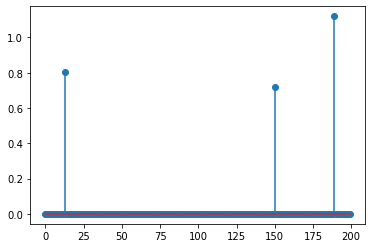

Text(0.5, 1.0, 'Stepsize')

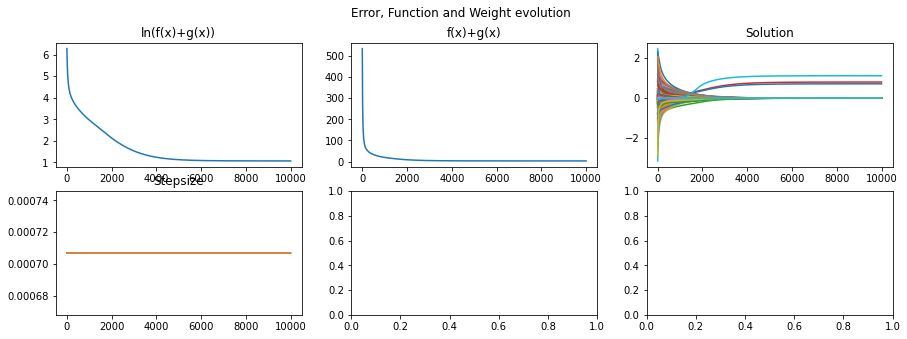

In [14]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 10000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [15]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / abs((st.T @ yt))

Final error: 2.9131940181997145
Final soln: [ 3.19258814e-20 -4.70165029e-20 -2.43408031e-27  5.46659030e-22
  5.58064218e-20  1.30485315e-23  1.03064459e-20  3.23512388e-24
 -2.88141846e-21  9.88529095e-26 -2.14447620e-15 -1.93947162e-23
  2.21193256e-16  8.05911277e-01  2.27438255e-19 -2.80831640e-25
  1.50578932e-28  1.34265764e-20  1.00235505e-26 -6.30259965e-25
  1.55601224e-22 -2.75650961e-27  1.70567678e-20 -3.26862459e-24
  2.96212129e-25 -1.43544841e-13  4.62995348e-16  2.16494136e-25
 -6.86075393e-28 -1.83326136e-20 -3.92563007e-27 -1.42708406e-25
  2.20494180e-24 -1.33083251e-20 -3.63110088e-15 -5.35030422e-17
  2.81268510e-18 -4.29727266e-22  1.41247798e-18  1.34795689e-25
 -7.54327785e-27 -9.06119363e-27  4.12301771e-24 -3.61376566e-25
 -2.18160992e-11 -2.67351101e-26 -7.31748125e-24  1.88801985e-26
  1.35248272e-23  5.59497335e-28 -2.91629110e-11  6.62559433e-24
  1.54652444e-29 -4.89045841e-22  3.38029889e-29  6.37015859e-27
  1.32398493e-21 -1.74811058e-14  1.69993755e-

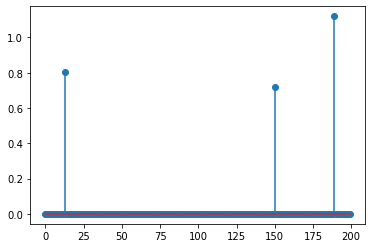

Text(0.5, 1.0, 'Stepsize')

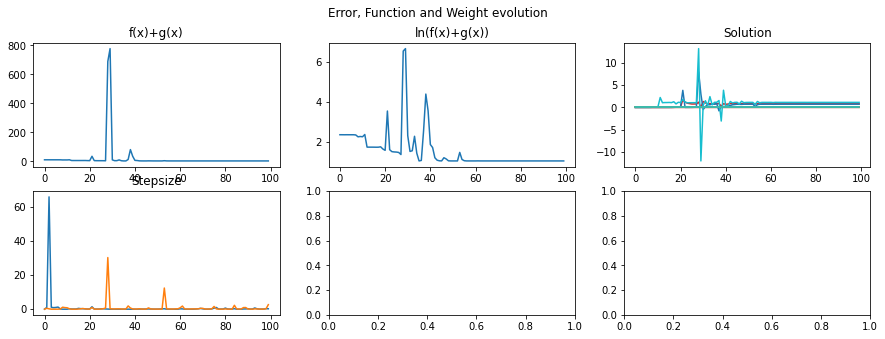

In [18]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 100
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
        stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    
print("Final error:", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec3.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec3.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [27]:
#Now try with real data - load MNIST digits
#(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Stochastic Gradient Descent
Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [21]:
#Check that sum of gradient is gradient of the sum
x = np.zeros(samples)
diff = A@x-y
grad = np.zeros(samples)
for i in range(features):
    grad = grad + diff[i] * A[i,:].T
    
print(np.linalg.norm(grad - GradF(A,x,y)))

8.610030086210007e-14


In [22]:
print(np.size(A,0))

100


In [18]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*features*u*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*v + features*u*(Xi @ (u*v) - y[indx])*Xi.T

In [19]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T
    #return lam*u + features*u*(Xi @ (u*v) - y[indx])*Xi.T

Final f(x)+g(x): 2.4827767841947583
|x-x0|_0 = 200.0
Subdifferential: 4.779772040279982


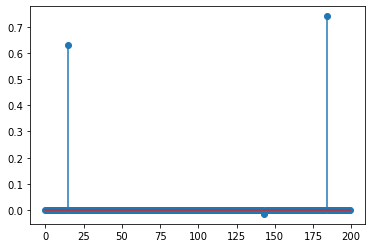

Text(0.5, 1.0, 'Stepsize')

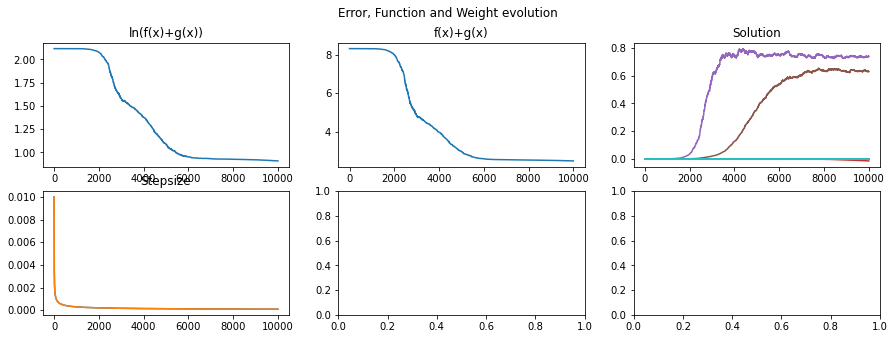

In [44]:
#Do SGD with decaying stepsize omg_k = omg_0 / (1 + k/10)
step = 0.001
niter = 10000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    rndindx = np.random.randint(features)
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    #stepu = step/(1+i/5)
    #stepv = step/(1+i/5)
    #stepu = 1/(1+i)
    #stepv = 1/(1+i)
    stepu = 0.01/(1+i)**0.51
    stepv = 0.01/(1+i)**0.51
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [17]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / abs((st.T @ yt))

In [18]:
def SGD_BB_k(xt,xtm1,gradt,gradtm1,Ckm1,phik,k,epoch_sz):    #Smoothing technique for the SGD BB step
    st = xt - xtm1
    yt = gradt - gradtm1
    bbk = (1/epoch_sz)*(st.T @ st) / abs((st.T @ yt))
    Ckopt = (bbk * phik) ** (1/(k-1))
    Ckm1opt = Ckm1 ** ((k-2)/(k-1))
    return Ckm1opt * Ckopt

Final f(x)+g(x): 2.417505844161857
Final soln: [ 9.37804876e-13  5.49631508e-14 -5.41454825e-09 -2.61821392e-12
 -3.23705007e-09  1.60576104e-13  6.31621671e-11 -3.94570967e-09
 -1.82737185e-10 -4.49432746e-09 -2.74783238e-13  3.58961234e-13
 -8.68435907e-13 -2.70267360e-11 -1.01573772e-11  1.26246062e-08
 -9.63559269e-09 -1.75553218e-10 -1.08375129e-10 -4.56103058e-10
 -1.43425369e-08 -1.60593134e-12  2.42385781e-10  7.51878471e-12
  1.08275820e-12  2.45695801e-10 -1.36753903e-10  5.32853827e-12
 -3.06047903e-13  1.22694115e-10  3.01091635e-12  1.53344576e-10
  6.85033517e-08 -3.34591546e-10 -3.40836850e-09 -7.24605171e-15
 -2.72085513e-10 -1.50162512e-09 -8.97247147e-14 -2.25645829e-11
  1.25481516e-07  5.96744325e-10 -5.21506812e-09 -6.45987628e-14
  8.78978905e-12  5.02528256e-13  8.65038195e-11  5.26512611e-10
  1.08075626e-10  5.87439702e-11 -9.63912367e-12  1.88750625e-13
  2.84035048e-11  9.46007783e-13 -2.15861927e-11 -1.14847486e-11
  2.13627309e-11  7.76688889e-10  2.1841302

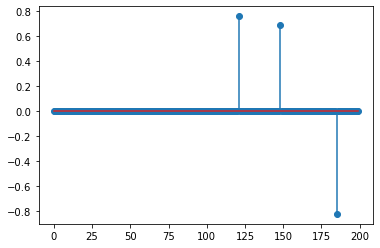

Text(0.5, 1.0, 'Stepsize')

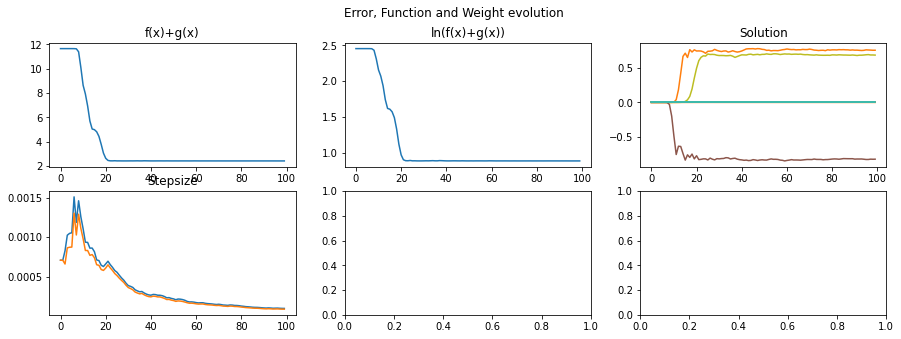

In [40]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein (SGD-BB in the paper)
step = 0.001
niter = 100
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp = np.zeros((samples,niter))
funcvec = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = features
epoch_u = 0
epoch_v = 0
beta = 10/(features)
for i in range(niter):
    phik = 1 + i
    
    if(i > 1):
        Ckm1u = SGD_BB_k(u,uold,gradu_avg,gradu_avg_old,Ckm1u,phik,i,epoch_sz)
        Ckm1v = SGD_BB_k(v,vold,gradv_avg,gradv_avg_old,Ckm1v,phik,i,epoch_sz)
        stepu = Ckm1u / phik
        stepv = Ckm1v / phik
        #stepu = (1/epoch_sz) * BBstep(u,uold,gradu_avg,gradu_avg_old)
        #stepv = (1/epoch_sz) * BBstep(v,vold,gradv_avg,gradv_avg_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i <= 1):
        Ckm1u = 1
        Ckm1v = 1
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
        gradu_avg = 0
        gradv_avg = 0
    gradu_avg_old = gradu_avg
    gradv_avg_old = gradv_avg
    gradu_avg = 0
    gradv_avg = 0
    for t in range(epoch_sz):
        rndindx = np.random.randint(0, features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        u = u - stepu * gradu
        v = v - stepv * gradv
        gradu_avg = beta * gradu + (1-beta) * gradu_avg
        gradv_avg = beta * gradv + (1-beta) * gradv_avg
    
    xtemp[:,i] = u * v
    funcvec[i] = funcreg(A,(u * v),y,lam)
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", u * v)
print("Subdifferential:", SubdifTest(A,u * v,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# SVRG-BB



Final f(x)+g(x): 2.4172441678731427
Subdifferential: 1.000289156137026


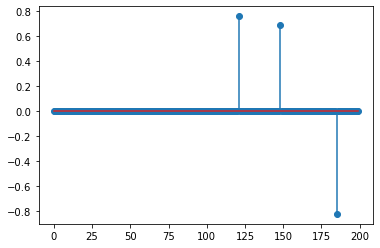

Text(0.5, 1.0, 'Stepsize')

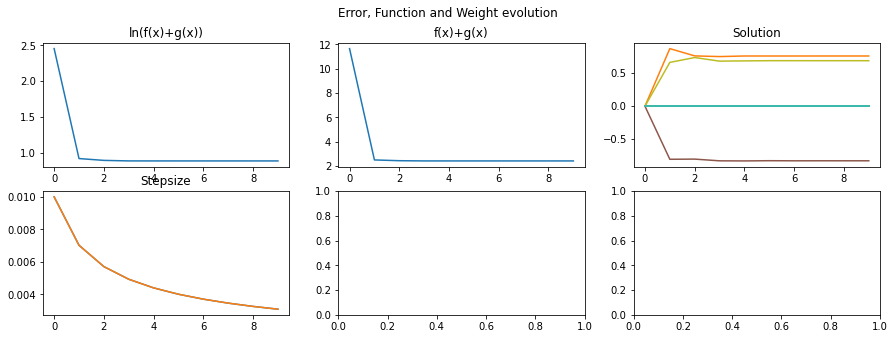

In [47]:
#Do SVRG with decreasing stepsize
step = 0.001
niter = 10
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
epoch_sz = 2*features
for i in range(niter):
    gradu_rl = GnabU(u,v,A,y,lam)
    gradv_rl = GnabV(u,v,A,y,lam)
    stepu = 0.01/(1+i)**0.51
    stepv = 0.01/(1+i)**0.51
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    x = u * v
    xtemp3[:,i] = x
    funcvec3[i] = funcreg(A,x,y,lam)
    u0 = u
    v0 = v
    for j in range(epoch_sz):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        gradu0 = SGnabU(u0,v0,A,y,lam,rndindx)
        gradv0 = SGnabV(u0,v0,A,y,lam,rndindx)
        u = u - stepu*(gradu_rl + gradu - gradu0)
        v = v - stepv*(gradv_rl + gradv - gradv0)
    
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Final f(x)+g(x): 2.417244142041704
Final soln: [ 7.36916313e-22  3.13798413e-22  1.74534618e-22 -4.16280037e-22
  4.42721564e-19  9.09127873e-21  2.00127289e-20 -1.90600129e-20
  5.70071015e-26 -9.51355788e-20  1.25960387e-21  4.11242291e-22
  4.75366304e-18  1.42746673e-22  2.32567399e-27 -1.88096178e-20
 -7.84258649e-24 -1.12621025e-19 -1.21922066e-24 -1.01774056e-19
 -2.35917439e-17 -9.93691522e-24  3.34199116e-25  4.42819901e-22
  1.27842741e-25  1.22364595e-22  1.54755293e-22 -4.27045373e-22
  5.15693230e-23 -1.65203095e-21  3.61546600e-21 -8.06710352e-27
 -1.13647578e-20  6.86405767e-20  9.31914355e-20 -6.61384541e-25
 -1.77494769e-21  1.89475465e-22 -2.42876794e-22 -1.33013981e-21
  4.99115023e-16  9.06176593e-19  5.05266348e-21 -3.93478310e-19
 -2.86283986e-25  7.63371495e-23  9.11295173e-17  1.83615187e-19
  1.13538927e-25  9.82520610e-25 -1.08411132e-18  3.86435082e-25
  4.34601368e-19 -2.47776182e-20 -8.63016723e-24 -5.27641204e-22
 -1.76622674e-20 -4.72391614e-18 -4.0753073

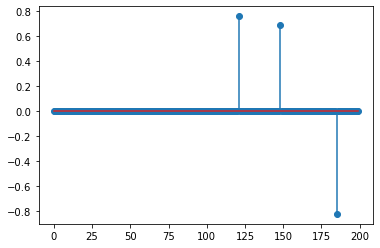

Text(0.5, 1.0, 'Stepsize')

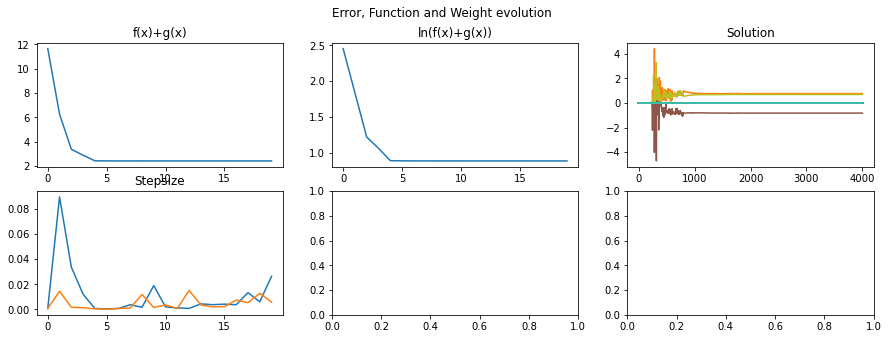

In [58]:
#Do SVRG-BB
step = 0.001
niter = 20
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp = np.zeros((samples,niter*epoch_sz))
funcvec = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = 2*features
epoch_u = 0
epoch_v = 0
beta = 10/(features)
gradu_rl = GnabU(u,v,A,y,lam)
gradv_rl = GnabV(u,v,A,y,lam)
for i in range(niter):
    gradu_rl_old = gradu_rl
    gradv_rl_old = gradv_rl
    gradu_rl = GnabU(u,v,A,y,lam)
    gradv_rl = GnabV(u,v,A,y,lam)
    
    if(i > 0):
        stepu = (1/epoch_sz) * BBstep(u,uold,gradu_rl,gradu_rl_old)
        stepv = (1/epoch_sz) * BBstep(v,vold,gradv_rl,gradv_rl_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i == 0):
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        steparr[0,i] = stepu
        steparr[1,i] = stepv

    for t in range(epoch_sz):
        rndindx = np.random.randint(features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        gradu0 = SGnabU(uold,vold,A,y,lam,rndindx)
        gradv0 = SGnabV(uold,vold,A,y,lam,rndindx)
        u = u - stepu*(gradu_rl + gradu - gradu0)
        v = v - stepv*(gradv_rl + gradv - gradv0)
        xtemp[:,i*epoch_sz+t] = u * v
    
    #xtemp[:,i] = u * v
    funcvec[i] = funcreg(A,(u * v),y,lam)
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", u * v)
print("Subdifferential:", SubdifTest(A,u * v,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [ ]:
def LineSearchSU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = SGnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

<ipython-input-115-bd4994221600>:3: RuntimeWarning: overflow encountered in matmul
  return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)
<ipython-input-112-c9be083c57c2>:6: RuntimeWarning: overflow encountered in matmul
  t = -c * grad.T @ grad
<ipython-input-159-fdcb03f5c9f8>:5: RuntimeWarning: overflow encountered in multiply
  return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T
<ipython-input-117-5b849e7e1fa9>:2: RuntimeWarning: overflow encountered in multiply
  return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)
<ipython-input-115-bd4994221600>:2: RuntimeWarning: invalid value encountered in matmul
  dif = X@(u * v) - y
<ipython-input-159-fdcb03f5c9f8>:4: RuntimeWarning: invalid value encountered in matmul
  Li = Xi @ (u*v) - y[indx]
<ipython-input-159-fdcb03f5c9f8>:5: RuntimeWarning: invalid value encountered in matmul
  return u + (1/lam)*features*v*(Xi @ (u*v) - y[indx])*Xi.T


Final f(x)+g(x): nan
Final soln: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
Subdifferential: nan


Text(0.5, 1.0, 'Stepsize')

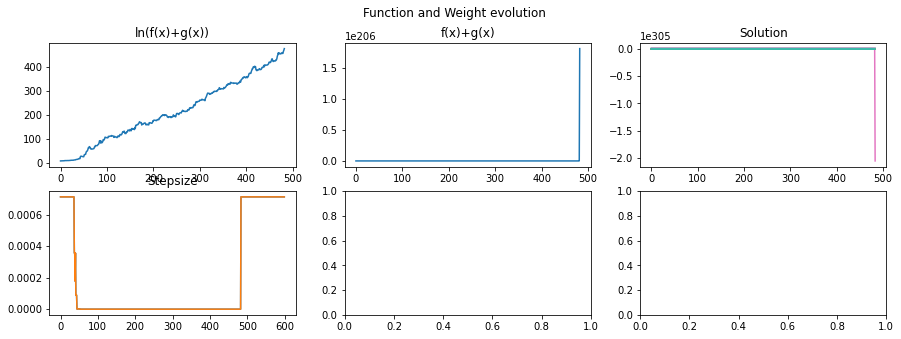

In [214]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 600
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    rndindx = np.random.randint(0, features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.

We have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla_{i} f(x_n)\right).$$
That is,
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{m} \sum_{j=1}^m g_j\right),$$
where
$$\mathbb{E} \left(g_j \right) = \nabla f(x_n)$$
and
$$ g_j = \frac{1}{\lambda}L_i \cdot A_i^T,$$
with $prox, L_i, A_i$ as above.

In [10]:
def SGnabX(X,x,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ x - y[indx]
    features = np.size(X,0)
    return features*Li*Xi.T

Final f(x)+g(x): 1.8741442396192731
Final soln: [ 0.00000000e+00 -0.00000000e+00 -6.58534211e-05  0.00000000e+00
 -2.95943700e-05  4.22244771e-05  0.00000000e+00 -0.00000000e+00
 -1.50037046e-05 -0.00000000e+00 -0.00000000e+00 -3.32089829e-05
  0.00000000e+00  0.00000000e+00 -3.33087343e-05  6.54949384e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.23558760e-05
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.34400623e-05
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -2.03991305e-05 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.27264026e-05 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.46981909e-04 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.19334930e-06  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.72846029e-05  0.00000000e+00  2.873771

Text(0.5, 1.0, 'Solution')

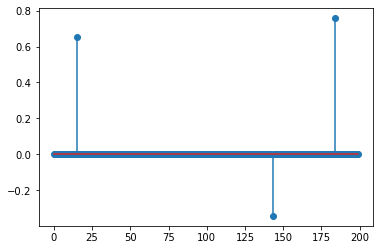

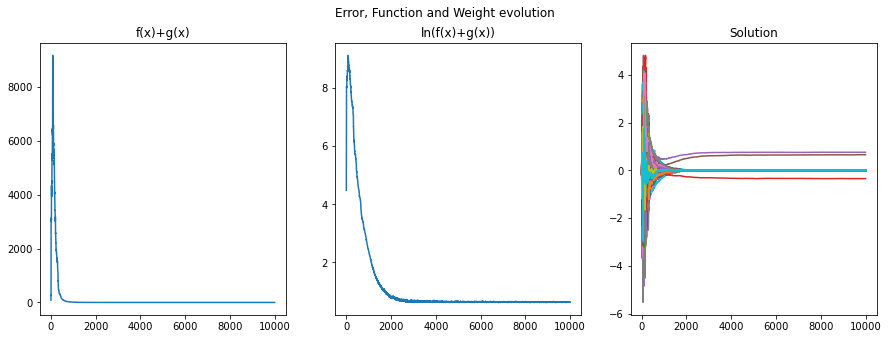

In [34]:
#Implement batch SGD Forward Backward alg
#initialize x_0 = 0
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
x = u*v;
#x = np.random.randn(samples)
niter = 10000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
omgk = omg
#mbs = round(features*0.8)        #minibatch size
for i in range(niter):
    grad = np.zeros(samples)
    rndindx = np.random.randint(features)
    #for j in range(mbs):          #Iterate over minibatch
    #    rndindx = np.random.randint(0, features)
    #    grad = grad + SGnabX(A,x,y,lam,rndindx)
    
    #grad = (1/mbs)*grad              #<---  It seems dividing by the batch size causes the algorithm to perform worse.
    grad = SGnabX(A,x,y,lam,rndindx)
    omgk = 0.001/(1+i)**0.51
    x = prox(x - omgk*grad,omgk*lam)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)

fig, axs4 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs4[0].plot(funcvec.T);
axs4[0].set_title('f(x)+g(x)')
axs4[1].plot(np.log(funcvec.T));
axs4[1].set_title('ln(f(x)+g(x))')
axs4[2].plot(xtemp.T);
axs4[2].set_title('Solution')


# Dual Averaging Method

In [42]:
def RDAstep(gt,t,lam,rho,gamma):
    lRDA = lam + rho/np.sqrt(t)
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lRDA:
            x[i] = 0
        else:
            x[i] = (-np.sqrt(t) / gamma) * (gt[i] - lRDA*np.sign(gt[i]))
            
    return x

Final f(x)+g(x): 1.3615920001645634
Final soln: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.57349456  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.16774623  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.  

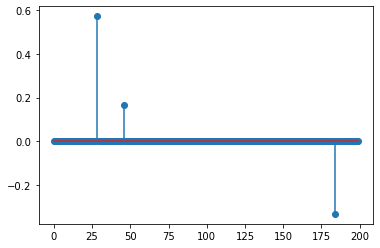

<ipython-input-54-4e8a967869b8>:36: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


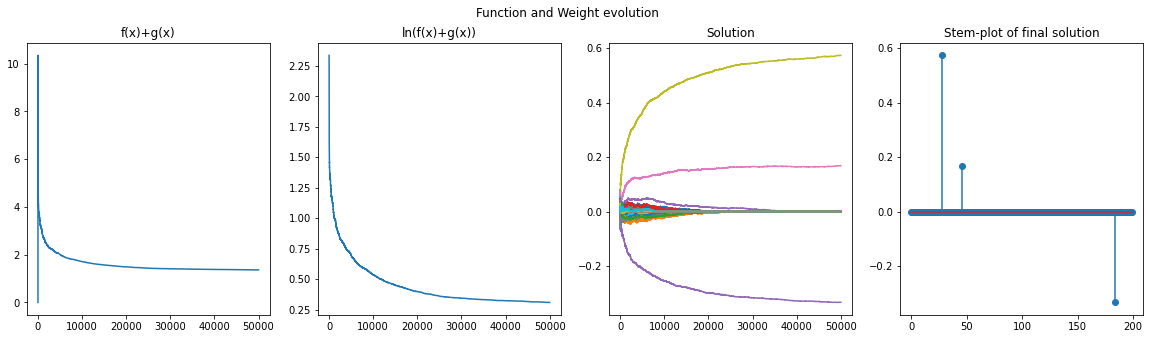

In [54]:
#Incorporate the RDA method as defined in paper by Lin Xiao
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 50000
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
rho = 0.001
gamma = 5000
gtavg = np.zeros(samples)

for i in range(1,niter):
    rndindx = np.random.randint(features)
    gt = SGnabX(A,x,y,lam,rndindx)    
    gtavg = ((i-1)/i) * gtavg + (1/i) * gt
    x = RDAstep(gtavg,i,lam,rho,gamma)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')

Final f(x)+g(x): 3.5050205118357782
|x-x0|_0 = 112.0
Subdifferential: 1.5914644700165996


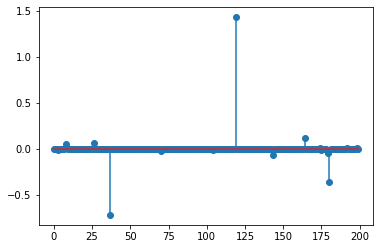

Text(0.5, 1.0, 'Solution')

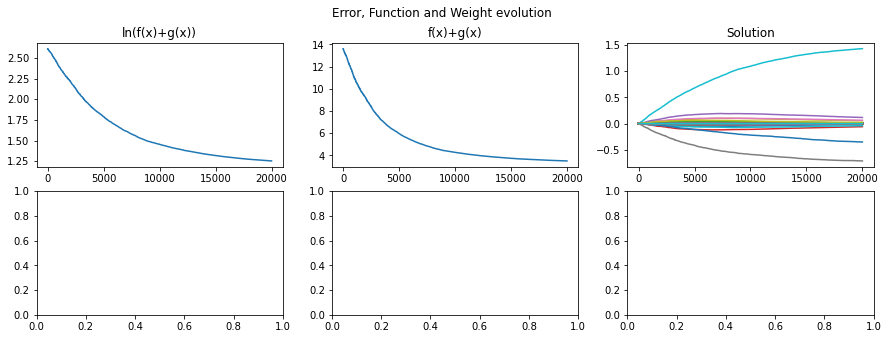

In [37]:
#Do ADAGRAD
step = 0.01
niter = 20000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
diagradu = np.zeros(samples)
diagradv = np.zeros(samples)
#beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-8) * np.ones(samples) * 0
#eps = np.zeros(samples)
for i in range(niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagradu[j] = diagradu[j] + (gradu[j])**2
        diagradv[j] = diagradv[j] + (gradv[j])**2
    stepu = omg / np.sqrt(diagradu + eps)
    stepv = omg / np.sqrt(diagradv + eps)
    #steparr[0,i] = stepu
    #steparr[1,i] = stepv
    u = u - stepu * gradu
    v = v - stepv * gradv
    x = u * v
    xtemp3[:,i] = x
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Final f(x)+g(x): 3.174290761410303
|x-x0|_0 = 3.0
Subdifferential: 1.2102018421476997


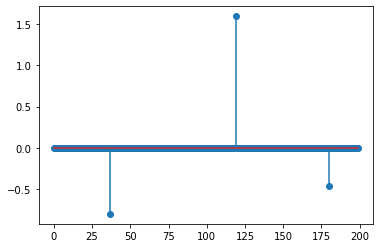

Text(0.5, 1.0, 'Solution')

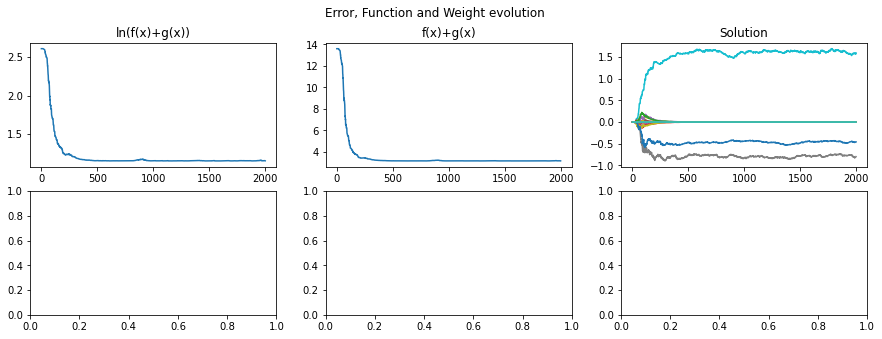

In [41]:
#Do ADADELTA
step = 0.01
niter = 2000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
diagradu = np.zeros(samples)
diagradv = np.zeros(samples)
beta = 0.95
#steparr = np.zeros((2,niter))
omg = 0.01
eps = 10**(-6) * np.ones(samples)
#eps = np.zeros(samples)
rmsu = np.zeros(samples)
rmsv = np.zeros(samples)
for i in range(niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagradu[j] = beta*diagradu[j] + (1-beta)*(gradu[j])**2
        diagradv[j] = beta*diagradv[j] + (1-beta)*(gradv[j])**2
    stepu = np.sqrt(rmsu + eps) / np.sqrt(diagradu + eps)
    stepv = np.sqrt(rmsv + eps) / np.sqrt(diagradv + eps)
    #steparr[0,i] = stepu
    #steparr[1,i] = stepv
    stepgradu = stepu * gradu
    stepgradv = stepv * gradv
    u = u - stepgradu
    v = v - stepgradv
    for j in range(samples):
        rmsu[j] = beta*rmsu[j] + (1-beta)*(stepgradu[j])**2
        rmsv[j] = beta*rmsv[j] + (1-beta)*(stepgradv[j])**2
    x = u * v
    xtemp3[:,i] = x
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

Final f(x)+g(x): 3.174366338767802
|x-x0|_0 = 200.0
Subdifferential: 0.9911482035312662


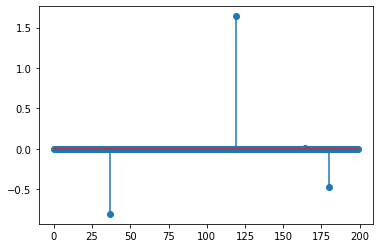

<ipython-input-54-b39629dd167f>:52: RuntimeWarning: divide by zero encountered in log
  axs3[0,0].plot(np.log(funcvec3.T));


Text(0.5, 1.0, 'Solution')

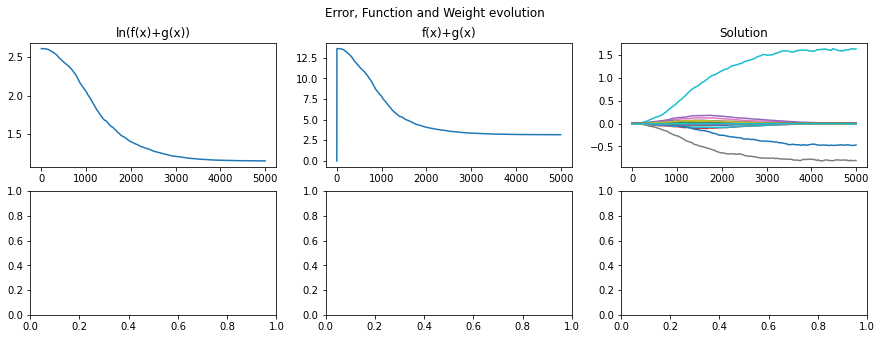

In [54]:
#Do ADAM
step = 0.01
niter = 5000
errvec3 = np.zeros(niter)
u = np.random.randn(samples)*0.0001
v = np.random.randn(samples)*0.0001
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
diagrad1u = np.zeros(samples)      #Initialize first moment estimate for u
diagrad1v = np.zeros(samples)      #Initialize first moment estimate for v
diagrad2u = np.zeros(samples)       #Initialize second moment estimate for u
diagrad2v = np.zeros(samples)       #Initialize second moment estimate for v
beta = 0.9        #Bias term for second moment estimate
beta2 = 0.999     #Bias term for first moment estimate
omg = 0.001        #Stepsize
eps = 10**(-8) * np.ones(samples)
for i in range(1,niter):
    rndindx = np.random.randint(features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    for j in range(samples):
        diagrad1u[j] = beta*diagrad1u[j] + (1-beta)*(gradu[j])
        diagrad1v[j] = beta*diagrad1v[j] + (1-beta)*(gradv[j])
        diagrad2u[j] = beta2*diagrad2u[j] + (1-beta2)*(gradu[j])**2
        diagrad2v[j] = beta2*diagrad2v[j] + (1-beta2)*(gradv[j])**2
        
        
    if (i > 0):                                      #Implement bias correction
        diagrad1u_b = diagrad1u / (1 - beta**i)
        diagrad1v_b = diagrad1v / (1 - beta**i)
        diagrad2u_b = diagrad2u / (1 - beta2**i)
        diagrad2v_b = diagrad2v / (1 - beta2**i)
        
    stepu = omg * diagrad1u_b / (np.sqrt(diagrad2u_b) + eps)
    stepv = omg * diagrad1v_b / (np.sqrt(diagrad2v_b) + eps)
    u = u - stepu
    v = v - stepv
    x = u * v
    xtemp3[:,i] = x
    funcvec3[i] = funcreg(A,x,y,lam)
    
print("Final f(x)+g(x):", funcvec3[-1])
#print("Final soln:", x)
#print("Original soln:", x0)
print("|x-x0|_0 =", np.linalg.norm(x-x0,0))
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(u*v)
plt.show()

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
#axs3[1,0].plot(steparr.T);
#axs3[1,0].set_title('Stepsize')

In [14]:
def ADGRDstep(gt,t,lam,step):
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lam:
            x[i] = 0
        else:
            x[i] = step[i] * (gt[i] - lam*np.sign(gt[i]))
            
    return x

Final f(x)+g(x): 13.592906441093785
Final soln: [-2.04923288e-06  1.61320625e-06  0.00000000e+00  2.72499990e-06
  0.00000000e+00 -9.40443509e-07  2.80694833e-06  0.00000000e+00
 -5.20697441e-06  0.00000000e+00  0.00000000e+00 -3.41571949e-06
  0.00000000e+00  4.82343856e-07  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -3.39124418e-06  1.45837823e-06  0.00000000e+00
 -1.72089835e-06  0.00000000e+00 -4.42648050e-07  3.64945822e-07
  0.00000000e+00  1.29827102e-06 -8.13890639e-06  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.56810766e-06
  0.00000000e+00 -3.26612456e-06  0.00000000e+00 -1.59255361e-06
  0.00000000e+00  1.31017398e-05  0.00000000e+00  0.00000000e+00
 -5.72536923e-07 -1.96410847e-06  0.00000000e+00  1.14727907e-06
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.91696896e-06
 -1.24677586e-07  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.66007711e-06  0.00000000e+00
 -2.71365282e-06  0.00000000e+00  0.000000

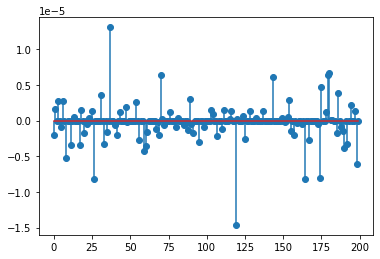

<ipython-input-42-abf45f3867e5>:39: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


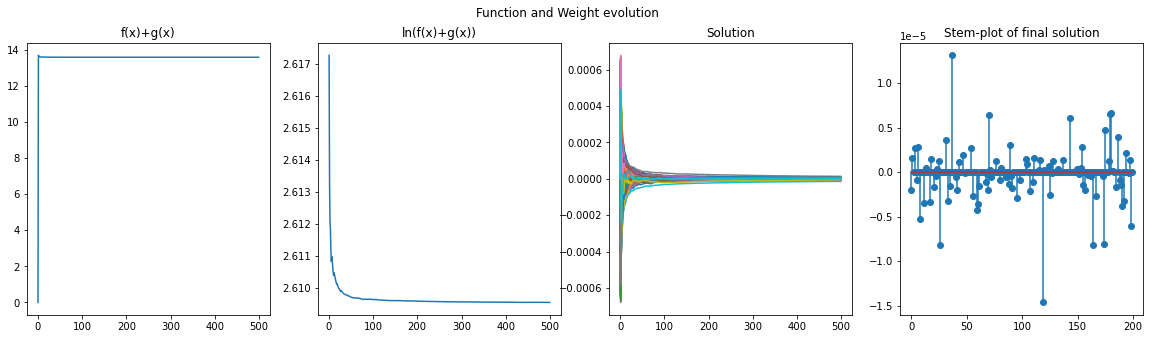

In [42]:
#Incorporate the L1-ADAGRAD method
x = np.random.randn(samples)*0.0001
gt = np.zeros(samples)
niter = 500
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
rho = 0.005
gamma = 5000
gtavg = np.zeros(samples)
diagrad = np.zeros(samples)
eps = 10**(-8) * np.ones(samples)

for i in range(1,niter):
    rndindx = np.random.randint(features)
    gt = SGnabX(A,x,y,lam,rndindx)    
    gtavg = ((i-1)/i) * gtavg + (1/i) * gt
    for j in range(samples):
        diagrad[j] = diagrad[j] + (gt[j])**2
    step = omg / (np.sqrt(diagrad)+eps)
    x = ADGRDstep(gtavg,i,lam,step)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))
plt.stem(x)
plt.show()

fig, axs5 = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')
axs5[3].stem(x);
axs5[3].set_title('Stem-plot of final solution')
plt.savefig('foo2.png')